In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer

In [92]:
# I read the csv with the good number of observations and the new column Red
df = pd.read_csv("modified_vin.csv")
df["description"] = df["description"].str.lower()
df["variety"].value_counts()


Pinot Noir            8378
Cabernet Sauvignon    8127
Chardonnay            8108
Riesling              3274
Merlot                3111
Malbec                1582
Sangiovese            1414
Zinfandel             1224
Name: variety, dtype: int64

In [93]:
# However, in the numerical model, we decided to remove all obs where the 4 cotinuous variables were equal to 0, so we have to align our nlp dataset
n_pinot_noir = 5888
n_chardonnay = 5633
n_cabernet_sauvignon = 4405
Riesling=2820
Merlot=2209
Malbec=1263
Zinfandel=940
Sangiovese=790
# filter the DataFrame to only keep the desired number of observations for each grape variety
df_filtered = pd.concat([
    df[df['variety'] == 'Pinot Noir'].sample(n_pinot_noir, random_state=42),
    df[df['variety'] == 'Chardonnay'].sample(n_chardonnay, random_state=42),
    df[df['variety'] == 'Cabernet Sauvignon'].sample(n_cabernet_sauvignon, random_state=42),
    df[df['variety'] == 'Riesling'].sample(Riesling, random_state=42),
    df[df['variety'] == 'Merlot'].sample(Merlot, random_state=42),
    df[df['variety'] == 'Malbec'].sample(Malbec, random_state=42),
    df[df['variety'] == 'Zinfandel'].sample(Zinfandel, random_state=42),
    df[df['variety'] == 'Sangiovese'].sample(Sangiovese, random_state=42),
    
])

# reset the index of the filtered DataFrame
df = df_filtered.reset_index(drop=True)
df["variety"].value_counts()

Pinot Noir            5888
Chardonnay            5633
Cabernet Sauvignon    4405
Riesling              2820
Merlot                2209
Malbec                1263
Zinfandel              940
Sangiovese             790
Name: variety, dtype: int64

In [94]:
# Creation of the list of stop_words
stop_variety = list(np.unique(df.variety.dropna().str.lower().tolist()))
stop_words =  stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop = stop_words + stop_append + stop_variety

In [95]:
# Lower casing the reviews
df["description"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))


0        broad-shouldered, full-bodied shows true varie...
1        bit disappointing. starts exciting blast cherr...
2        tons flavor pinot. dazzles waves cherries, rhu...
3        initially spicy, develops awkward barnyard cha...
4        delicious first word pops head taste wine. got...
                               ...                        
23943    modern brunello dark, inky concentration toast...
23944    opens sweet bursting cherry, marzipan, cinnamo...
23945    here's classically crafted selection, lovely f...
23946    captivating wild berry, rose, chopped herb bak...
23947    obviously shaped hot vintage, riserva delivers...
Name: description, Length: 23948, dtype: object

In [96]:
# Dataset Overview
df.head()

,description,variety,Red
0,"this is a broad-shouldered, full-bodied wine t...",Pinot Noir,1
1,a bit disappointing. starts off with an exciti...,Pinot Noir,1
2,tons of flavor in this pinot. dazzles with wav...,Pinot Noir,1
3,"initially spicy, this wine then develops an aw...",Pinot Noir,1
4,delicious is the first word that pops into you...,Pinot Noir,1


In [97]:
# create red_wine_df by selecting rows where Red column equals 1
red_wine_df = df.loc[df['Red'] == 1]

# create white_wine_df by selecting rows where Red column equals 0
white_wine_df = df.loc[df['Red'] == 0]

In [98]:
# Transforming categorial classes into numerical classes for red wines
red_wine_df = red_wine_df.dropna()
le = LabelEncoder()
red_wine_df['variety_enc'] = le.fit_transform(red_wine_df['variety'])
red_wine_df.head(35000)

,description,variety,Red,variety_enc
0,"this is a broad-shouldered, full-bodied wine t...",Pinot Noir,1,3
1,a bit disappointing. starts off with an exciti...,Pinot Noir,1,3
2,tons of flavor in this pinot. dazzles with wav...,Pinot Noir,1,3
3,"initially spicy, this wine then develops an aw...",Pinot Noir,1,3
4,delicious is the first word that pops into you...,Pinot Noir,1,3
...,...,...,...,...
23943,"a modern brunello with dark, inky concentratio...",Sangiovese,1,4
23944,the wine opens with sweet aromas of bursting c...,Sangiovese,1,4
23945,"here's a classically crafted selection, with a...",Sangiovese,1,4
23946,"captivating wild berry, rose, chopped herb and...",Sangiovese,1,4


In [99]:
# Transforming categorial classes into numerical classes for white wines
white_wine_df = white_wine_df.dropna()
le = LabelEncoder()
white_wine_df['variety_enc'] = le.fit_transform(white_wine_df['variety'])
white_wine_df.head(35000)

,description,variety,Red,variety_enc
5888,"could be a cool-climate sauvignon blanc, with ...",Chardonnay,0,0
5889,"this serious, complex selection features a liv...",Chardonnay,0,0
5890,tangerine and citrus aromas give the bouquet a...,Chardonnay,0,0
5891,"somewhat thick and pulpy in texture, with chun...",Chardonnay,0,0
5892,"a creamy wine, its apple fruit flavors smoothe...",Chardonnay,0,0
...,...,...,...,...
18741,already showing signs of the kerosene aromas t...,Riesling,0,1
18742,beautifully pure notes of crisp cox's orange p...,Riesling,0,1
18743,fragrant yellow and purple flowers on the nose...,Riesling,0,1
18744,"this is a pure, aesthetic wine, delicately out...",Riesling,0,1


In [100]:
# Split the data into training and test sets (80% training, 20% test) for red wines
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(red_wine_df['description'], red_wine_df['variety_enc'], test_size=0.2, random_state=42)

# Split the test data into test and validation sets (50% test, 50% validation) for red wines
X_red_test, X_red_val, y_red_test, y_red_val = train_test_split(X_red_test, y_red_test, test_size=0.5, random_state=42)

In [101]:
# Split the data into training and test sets (80% training, 20% test) for white wines
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(white_wine_df['description'], white_wine_df['variety_enc'], test_size=0.2, random_state=42)

# Split the test data into test and validation sets (50% test, 50% validation) for white wines
X_white_test, X_white_val, y_white_test, y_white_val = train_test_split(X_white_test, y_white_test, test_size=0.5, random_state=42)

In [102]:
#Compute class_weights for red wines
class_weights = {}
for i in range(len(np.unique(y_red_train))):
    class_weights[i] = 1 / 8

print(class_weights)

{0: 0.125, 1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125}


In [103]:
#Compute class_weights for white wines
class_weights2 = {}
for i in range(len(np.unique(y_white_train))):
    class_weights2[i] = 1 / 8

print(class_weights2)

{0: 0.125, 1: 0.125}


In [104]:
# We load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [105]:
print(tokenizer("Hello world")['input_ids'])

[101, 7592, 2088, 102]


In [106]:
# We tokenize our train and test sets for red wines
train_red_encodings = tokenizer(list(X_red_train), truncation=True, padding=True)
test_red_encodings = tokenizer(list(X_red_test), truncation=True, padding=True)

In [107]:
# We tokenize our train and test sets for white wines
train_white_encodings = tokenizer(list(X_white_train), truncation=True, padding=True)
test_white_encodings = tokenizer(list(X_white_test), truncation=True, padding=True)

In [108]:
validation_red_encodings = tokenizer(list(X_red_val), truncation=True, padding=True)

In [109]:
validation_white_encodings = tokenizer(list(X_white_val), truncation=True, padding=True)

In [110]:
# We convert our sets in tensor format
train_red_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_red_encodings),
    y_red_train
)).shuffle(len(X_red_train)).batch(32)

test_red_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_red_encodings),
    y_red_test
)).batch(32)


In [111]:
# We convert our sets in tensor format
train_white_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_white_encodings),
    y_white_train
)).shuffle(len(X_white_train)).batch(32)

test_white_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_white_encodings),
    y_white_test
)).batch(32)


In [112]:
# Configure the BERT model for red wines
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(np.unique(y_red_train)))
print(config)


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [114]:
# Configure the BERT model for white wines
config2 = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(np.unique(y_white_train)))
print(config2)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [115]:
# We load two pre-trained models
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config2)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
# We compile our two models
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])
model2.compile(optimizer=Adam(learning_rate=2e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [117]:
# We build our two early stoppins
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
es2 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [118]:
# We fit the model on red wines
history = model.fit(train_red_dataset,
                    epochs=3,
                    validation_data=test_red_dataset,
                    callbacks=[es],
                    class_weight=class_weights)

Epoch 1/3
388/388 [==============================] - 462s 1s/step - loss: 0.1125 - sparse_categorical_accuracy: 0.6866 - val_loss: 0.6252 - val_sparse_categorical_accuracy: 0.7870
Epoch 2/3
388/388 [==============================] - 418s 1s/step - loss: 0.0650 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.5326 - val_sparse_categorical_accuracy: 0.8167
Epoch 3/3
388/388 [==============================] - 415s 1s/step - loss: 0.0475 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.5336 - val_sparse_categorical_accuracy: 0.8108


In [119]:
# We fit the model for white wines
history2 = model2.fit(train_white_dataset,
                    epochs=3,
                    validation_data=test_white_dataset,
                    callbacks=[es2],
                    class_weight=class_weights2)

Epoch 1/3
212/212 [==============================] - 251s 960ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.1634 - val_sparse_categorical_accuracy: 0.9266
Epoch 2/3
212/212 [==============================] - 205s 969ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.1572 - val_sparse_categorical_accuracy: 0.9444
Epoch 3/3
212/212 [==============================] - 207s 977ms/step - loss: 0.0078 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.1530 - val_sparse_categorical_accuracy: 0.9491


In [120]:
# Load the test data and encode it with the same tokenizer used for training
validation_red_encodings = tokenizer(list(X_red_val), truncation=True, padding=True)

# Create a TensorFlow Dataset from the encoded test data and labels
validation_dataset_red = tf.data.Dataset.from_tensor_slices((dict(validation_red_encodings), y_red_val)).batch(32)
print(validation_dataset_red)

# Load the test data and encode it with the same tokenizer used for training
validation_white_encodings = tokenizer(list(X_white_val), truncation=True, padding=True)


# Create a TensorFlow Dataset from the encoded test data and labels
validation_dataset_white = tf.data.Dataset.from_tensor_slices((dict(validation_white_encodings), y_white_val)).batch(32)
print(validation_dataset_white)

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 134), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 134), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 134), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 123), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 123), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 123), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [121]:
# Make predictions on test dataset
predictions_red = model.predict(validation_dataset_red)
print(len(validation_dataset_red))
# Make predictions on test dataset
predictions_white = model2.predict(validation_dataset_white)

49/49 [==============================] - 17s 278ms/step
49
27/27 [==============================] - 10s 252ms/step


In [122]:
logits = predictions_red.logits
# Get the predicted labels
label_list = [0,1,2,3,4,5]
predicted_labels_red = tf.argmax(logits, axis=-1).numpy()
predicted_labels_red = [label_list[label] for label in predicted_labels_red]

# Print the classification report
print(classification_report(y_red_val, predicted_labels_red))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       462
           1       0.89      0.46      0.61       110
           2       0.64      0.74      0.69       229
           3       0.85      0.96      0.90       590
           4       0.89      0.78      0.83        73
           5       0.95      0.69      0.80        86

    accuracy                           0.82      1550
   macro avg       0.85      0.74      0.78      1550
weighted avg       0.83      0.82      0.82      1550



In [123]:
logits = predictions_white.logits
# Get the predicted labels
label_list = [0,1]
predicted_labels = tf.argmax(logits, axis=-1).numpy()
predicted_labels_white = [label_list[label] for label in predicted_labels]

# Print the classification report
print(classification_report(y_white_val, predicted_labels_white))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       572
           1       0.97      0.92      0.94       274

    accuracy                           0.96       846
   macro avg       0.96      0.95      0.96       846
weighted avg       0.96      0.96      0.96       846



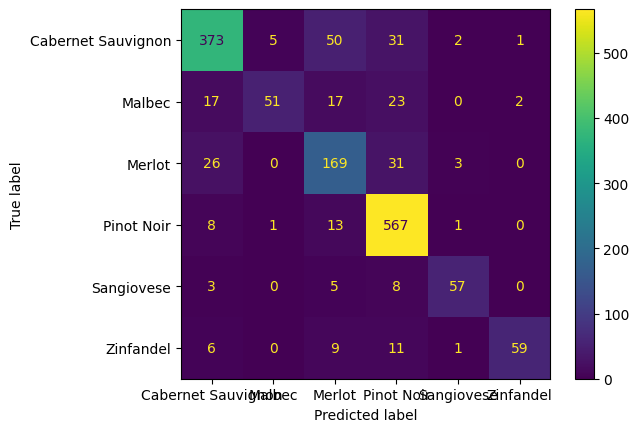

In [124]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_red_val,predicted_labels_red)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Cabernet Sauvignon" ,"Malbec","Merlot","Pinot Noir","Sangiovese","Zinfandel"])

cm_display.plot()
plt.show()

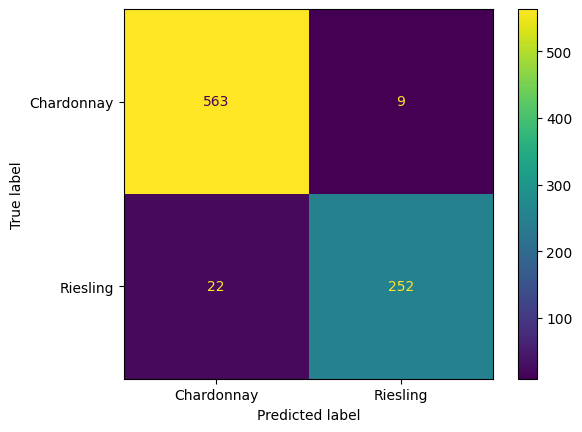

In [125]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_white_val,predicted_labels_white)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [ "Chardonnay","Riesling"])

cm_display.plot()
plt.show()